In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

2023-04-03 15:55:23.214953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 15:55:24.102223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device(type='cuda', index=0)

In [2]:
df = pd.read_csv("medium_ML_final_sampled_id.csv")
df.head()

,category,stemmed_text,category_id
0,business,"['analog', 'bank', 'digit', 'age', 'background...",1
1,business,"['prepar', 'small', 'mid', 'centuri', 'modern'...",1
2,business,"['profoto', 'ru', 'portal', 'publish', 'review...",1
3,business,"['time', 'growth', 'reward', 'canuklab', 'inc'...",1
4,business,"['gave', 'figur', 'salari', 'start', 'riski', ...",1


In [3]:
import ast

# Convert the list-like strings in the 'stemmed_text' column to space-separated strings
df['stemmed_text'] = df['stemmed_text'].apply(lambda x: ' '.join(ast.literal_eval(x)))

# Display the updated DataFrame
df.head()


,category,stemmed_text,category_id
0,business,analog bank digit age background jpmorgan chas...,1
1,business,prepar small mid centuri modern studi room jam...,1
2,business,profoto ru portal publish review photo equip a...,1
3,business,time growth reward canuklab inc born th decemb...,1
4,business,gave figur salari start riski ventur alway kne...,1


In [4]:
PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 300
BATCH_SIZE = 16
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.stemmed_text.to_numpy(),
    targets=df.category_id.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [5]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 300])
torch.Size([16, 300])
torch.Size([16])


In [6]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)


In [8]:
model = SentimentClassifier(6)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [10]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1696, 0.0989, 0.1550, 0.1328, 0.3374, 0.1063],
        [0.1855, 0.1006, 0.2009, 0.1225, 0.2554, 0.1352],
        [0.1269, 0.1481, 0.1480, 0.1405, 0.3318, 0.1048],
        [0.0835, 0.0862, 0.1300, 0.1382, 0.4833, 0.0788],
        [0.1913, 0.1499, 0.1847, 0.1369, 0.2380, 0.0994],
        [0.1751, 0.1332, 0.1584, 0.1116, 0.3238, 0.0979],
        [0.1202, 0.1067, 0.1689, 0.1373, 0.3872, 0.0796],
        [0.1438, 0.0970, 0.2588, 0.1319, 0.2402, 0.1283],
        [0.1699, 0.1303, 0.1483, 0.1654, 0.2579, 0.1282],
        [0.1566, 0.1489, 0.1586, 0.1074, 0.3299, 0.0985],
        [0.1498, 0.1230, 0.2095, 0.1665, 0.2623, 0.0890],
        [0.2051, 0.0850, 0.1786, 0.1565, 0.2383, 0.1365],
        [0.1202, 0.1067, 0.1794, 0.1601, 0.3373, 0.0963],
        [0.1626, 0.1081, 0.2217, 0.1537, 0.2720, 0.0818],
        [0.1316, 0.1293, 0.1784, 0.1245, 0.2845, 0.1517],
        [0.1535, 0.0888, 0.1095, 0.1488, 0.3875, 0.1120]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [11]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [13]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [15]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  train_acc_list.append(train_acc.item())
  train_loss_list.append(train_loss.item())
  val_acc_list.append(val_acc.item())
  val_loss_list.append(val_loss.item())

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 1.0114015067924507 accuracy 0.6239869680309509
Val   loss 0.9178728353838588 accuracy 0.6693548387096774

Epoch 2/3
----------
Train loss 0.753837581372028 accuracy 0.7344329057218489
Val   loss 0.8933253097672795 accuracy 0.6759530791788856

Epoch 3/3
----------
Train loss 0.6311768608052489 accuracy 0.7820403176542455
Val   loss 0.9119356021631596 accuracy 0.6803519061583577

CPU times: user 2h 17min 5s, sys: 27 s, total: 2h 17min 32s
Wall time: 2h 17min 57s


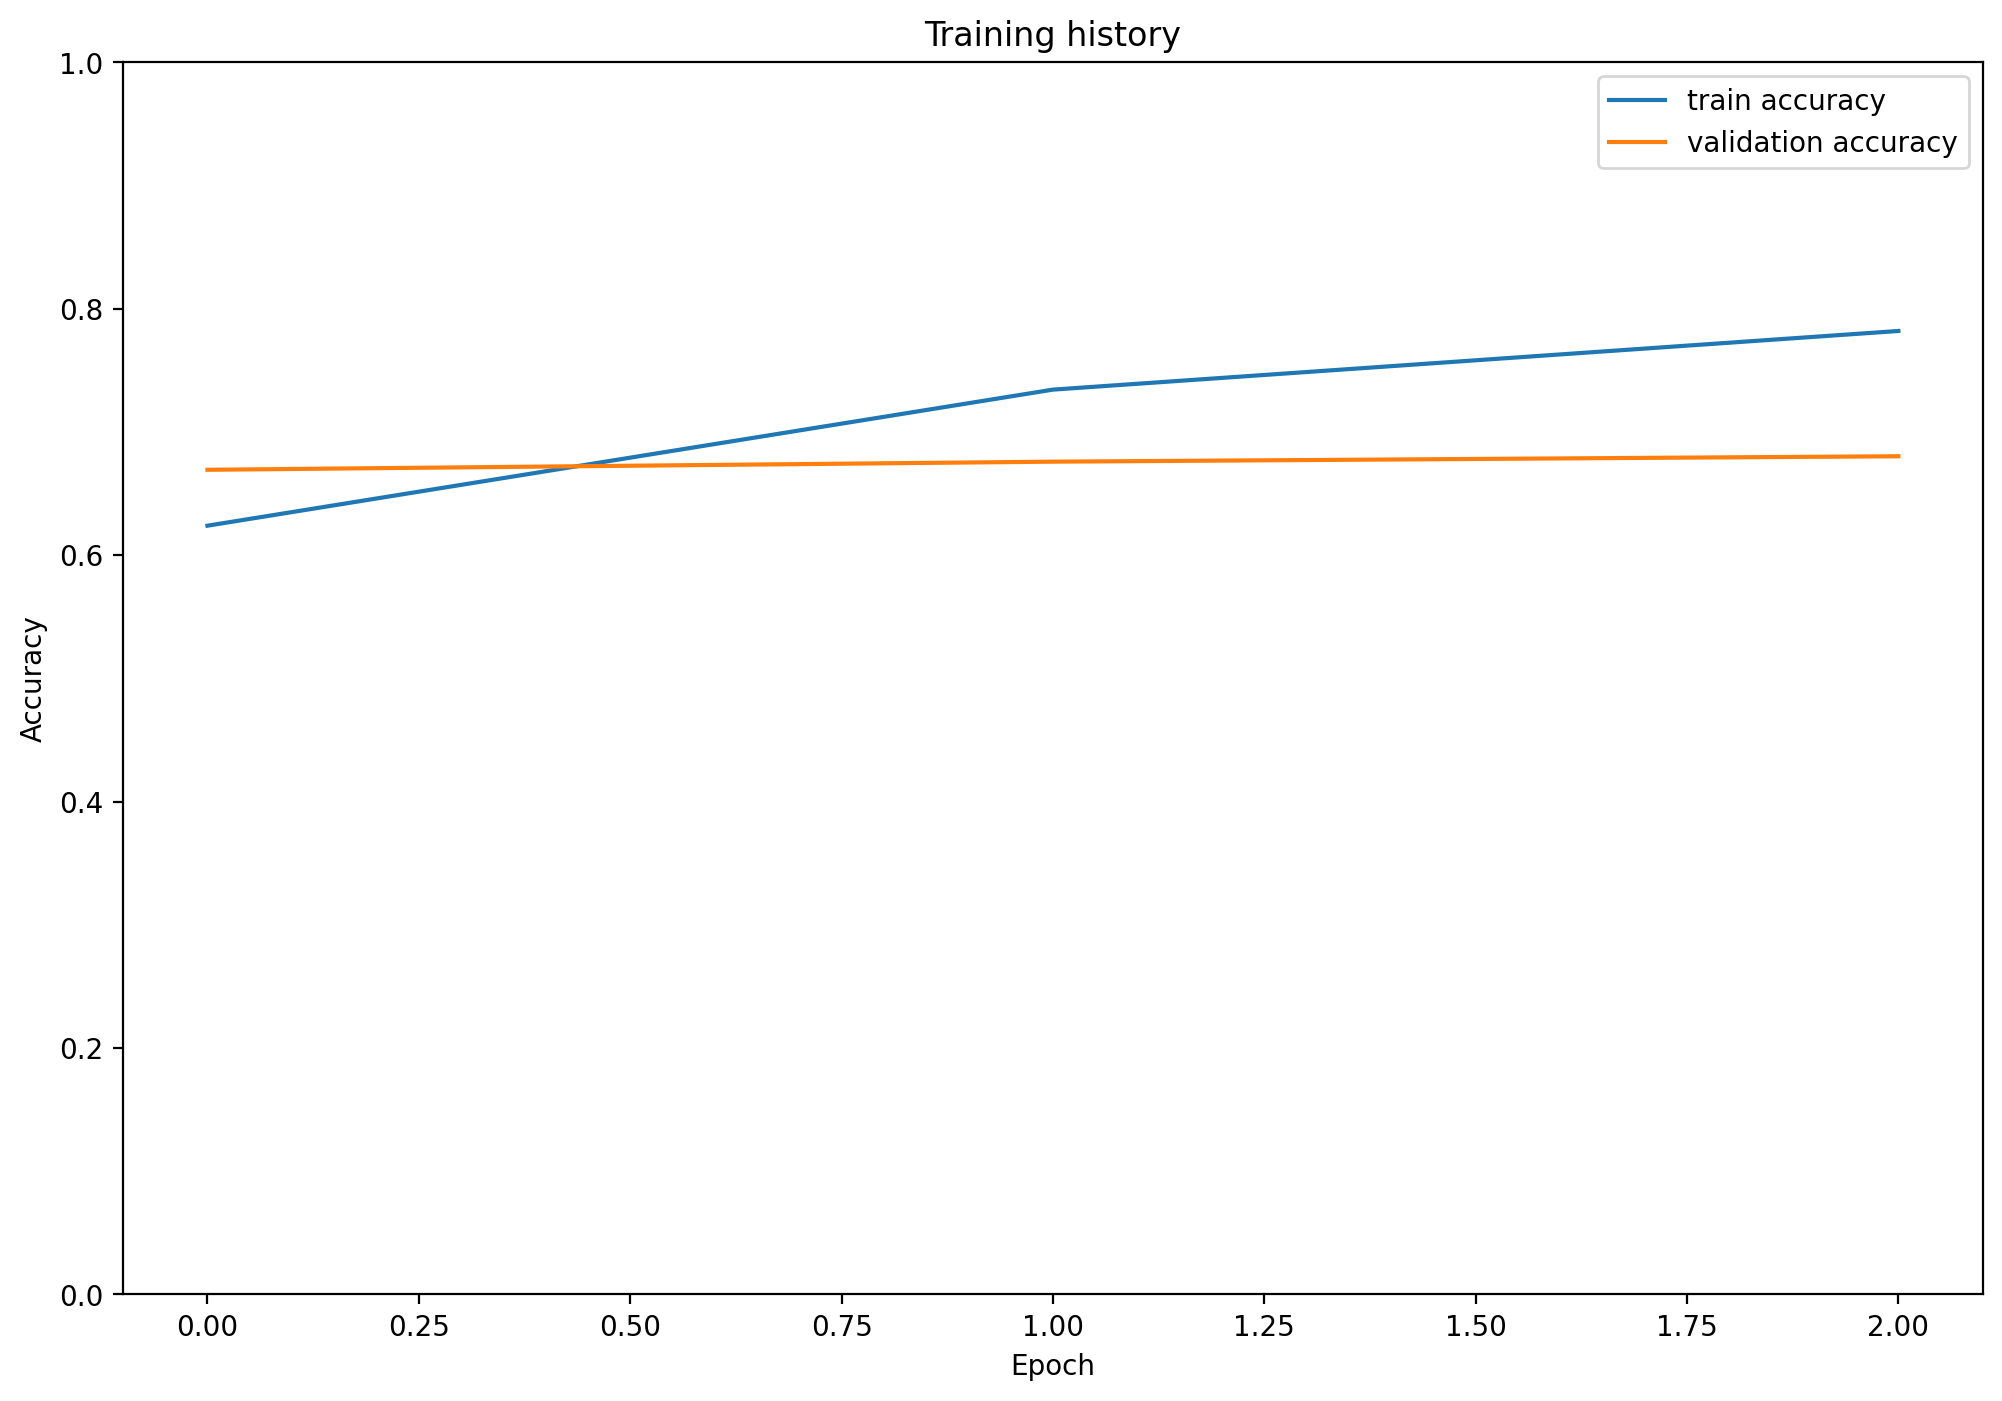

In [16]:
plt.plot(train_acc_list, label='train accuracy')
plt.plot(val_acc_list, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [17]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7025641025641025

In [18]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [19]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [21]:
category_names = ['programming','business','health','marketing','politics','sports']

In [22]:
print(classification_report(y_test, y_pred, target_names=category_names))

              precision    recall  f1-score   support

 programming       0.76      0.78      0.77       258
    business       0.63      0.58      0.60       245
      health       0.69      0.68      0.68       258
   marketing       0.69      0.72      0.71       260
    politics       0.68      0.69      0.68       240
      sports       0.83      0.83      0.83       104

    accuracy                           0.70      1365
   macro avg       0.71      0.71      0.71      1365
weighted avg       0.70      0.70      0.70      1365



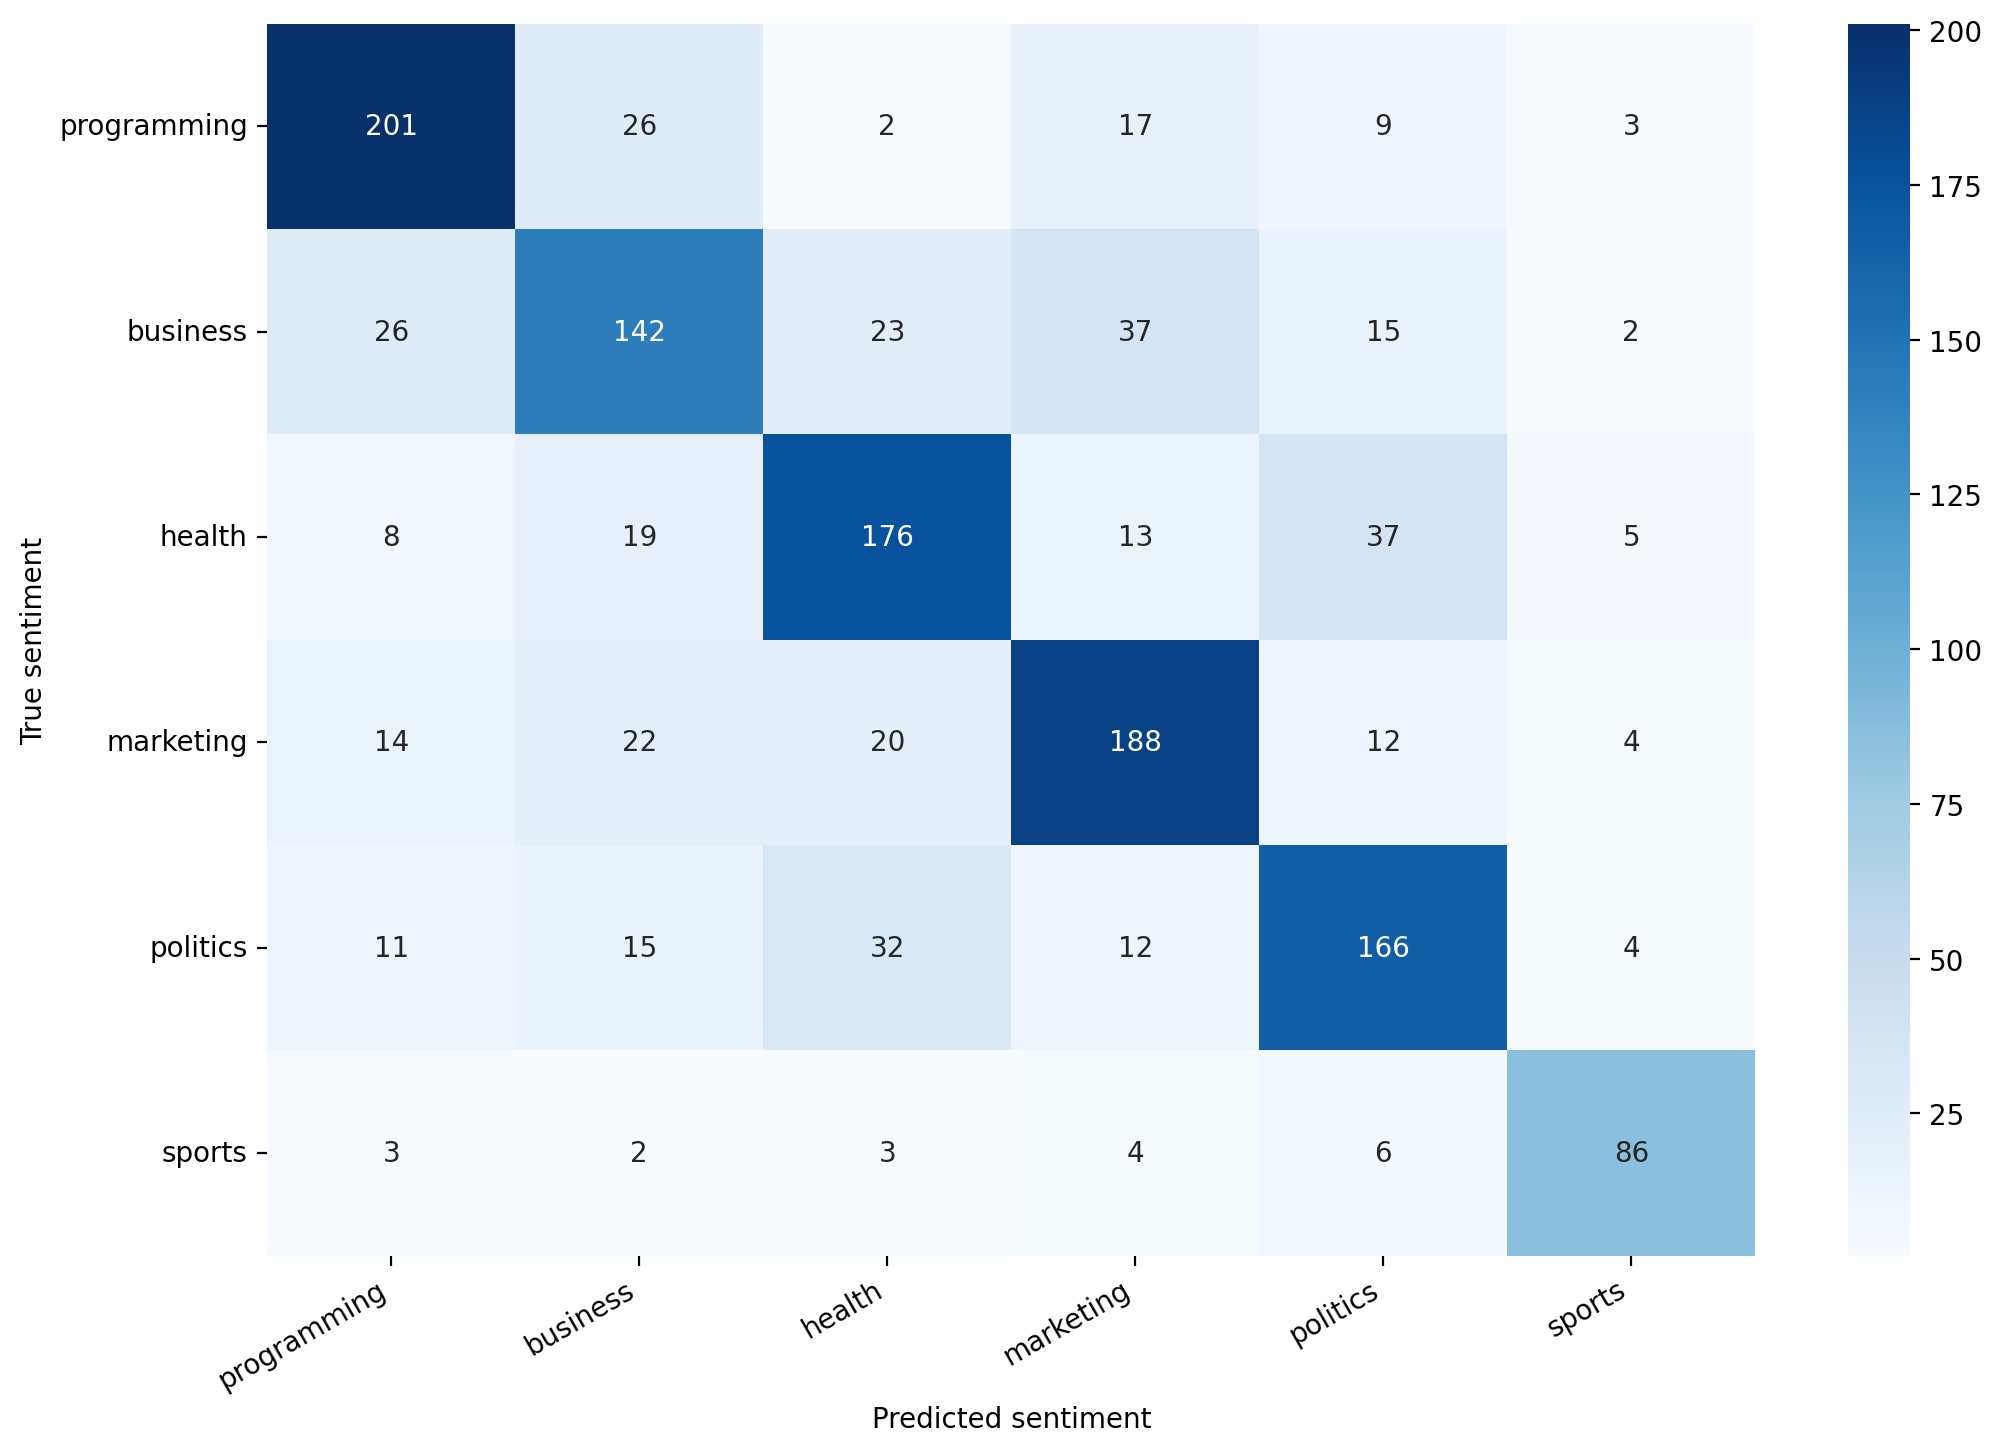

In [28]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=category_names, columns=category_names)
show_confusion_matrix(df_cm)

In [49]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': category_names,
  'values': y_pred_probs[idx]
})

In [50]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {category_names[true_sentiment]}')

mani peopl attempt lose weight succeed other fail howev biggest battl
peopl abl reduc weight often keep ideal weight mani peopl find soon
return weight went diet even actual fatter cours depress result lose
lot self esteem need perman solut weight problem obviou rout take
battl lose weight would includ increas amount exercis reduc amount eat
eat issu hardest control reduc temptat often get better us opinion
need make hous fat free zone becom hungri start look cupboard notic
exampl packet crisp often difficult eat desir instant food becom great
inner demon tri convinc us one packet hurt packet crisp cupboard would
put posit temptat would cours abl eat number year ago went lose excess
weight decid remov food cupboard awar need stop eat also remov certain
drink alcohol drink also someth contribut weight problem put dustbin
takeaway menu basic attempt make hard possibl eat drink anyth determin
keep diet tempt buy item shop etc easi somebodi love fatti type food
weekli food shop bought far 

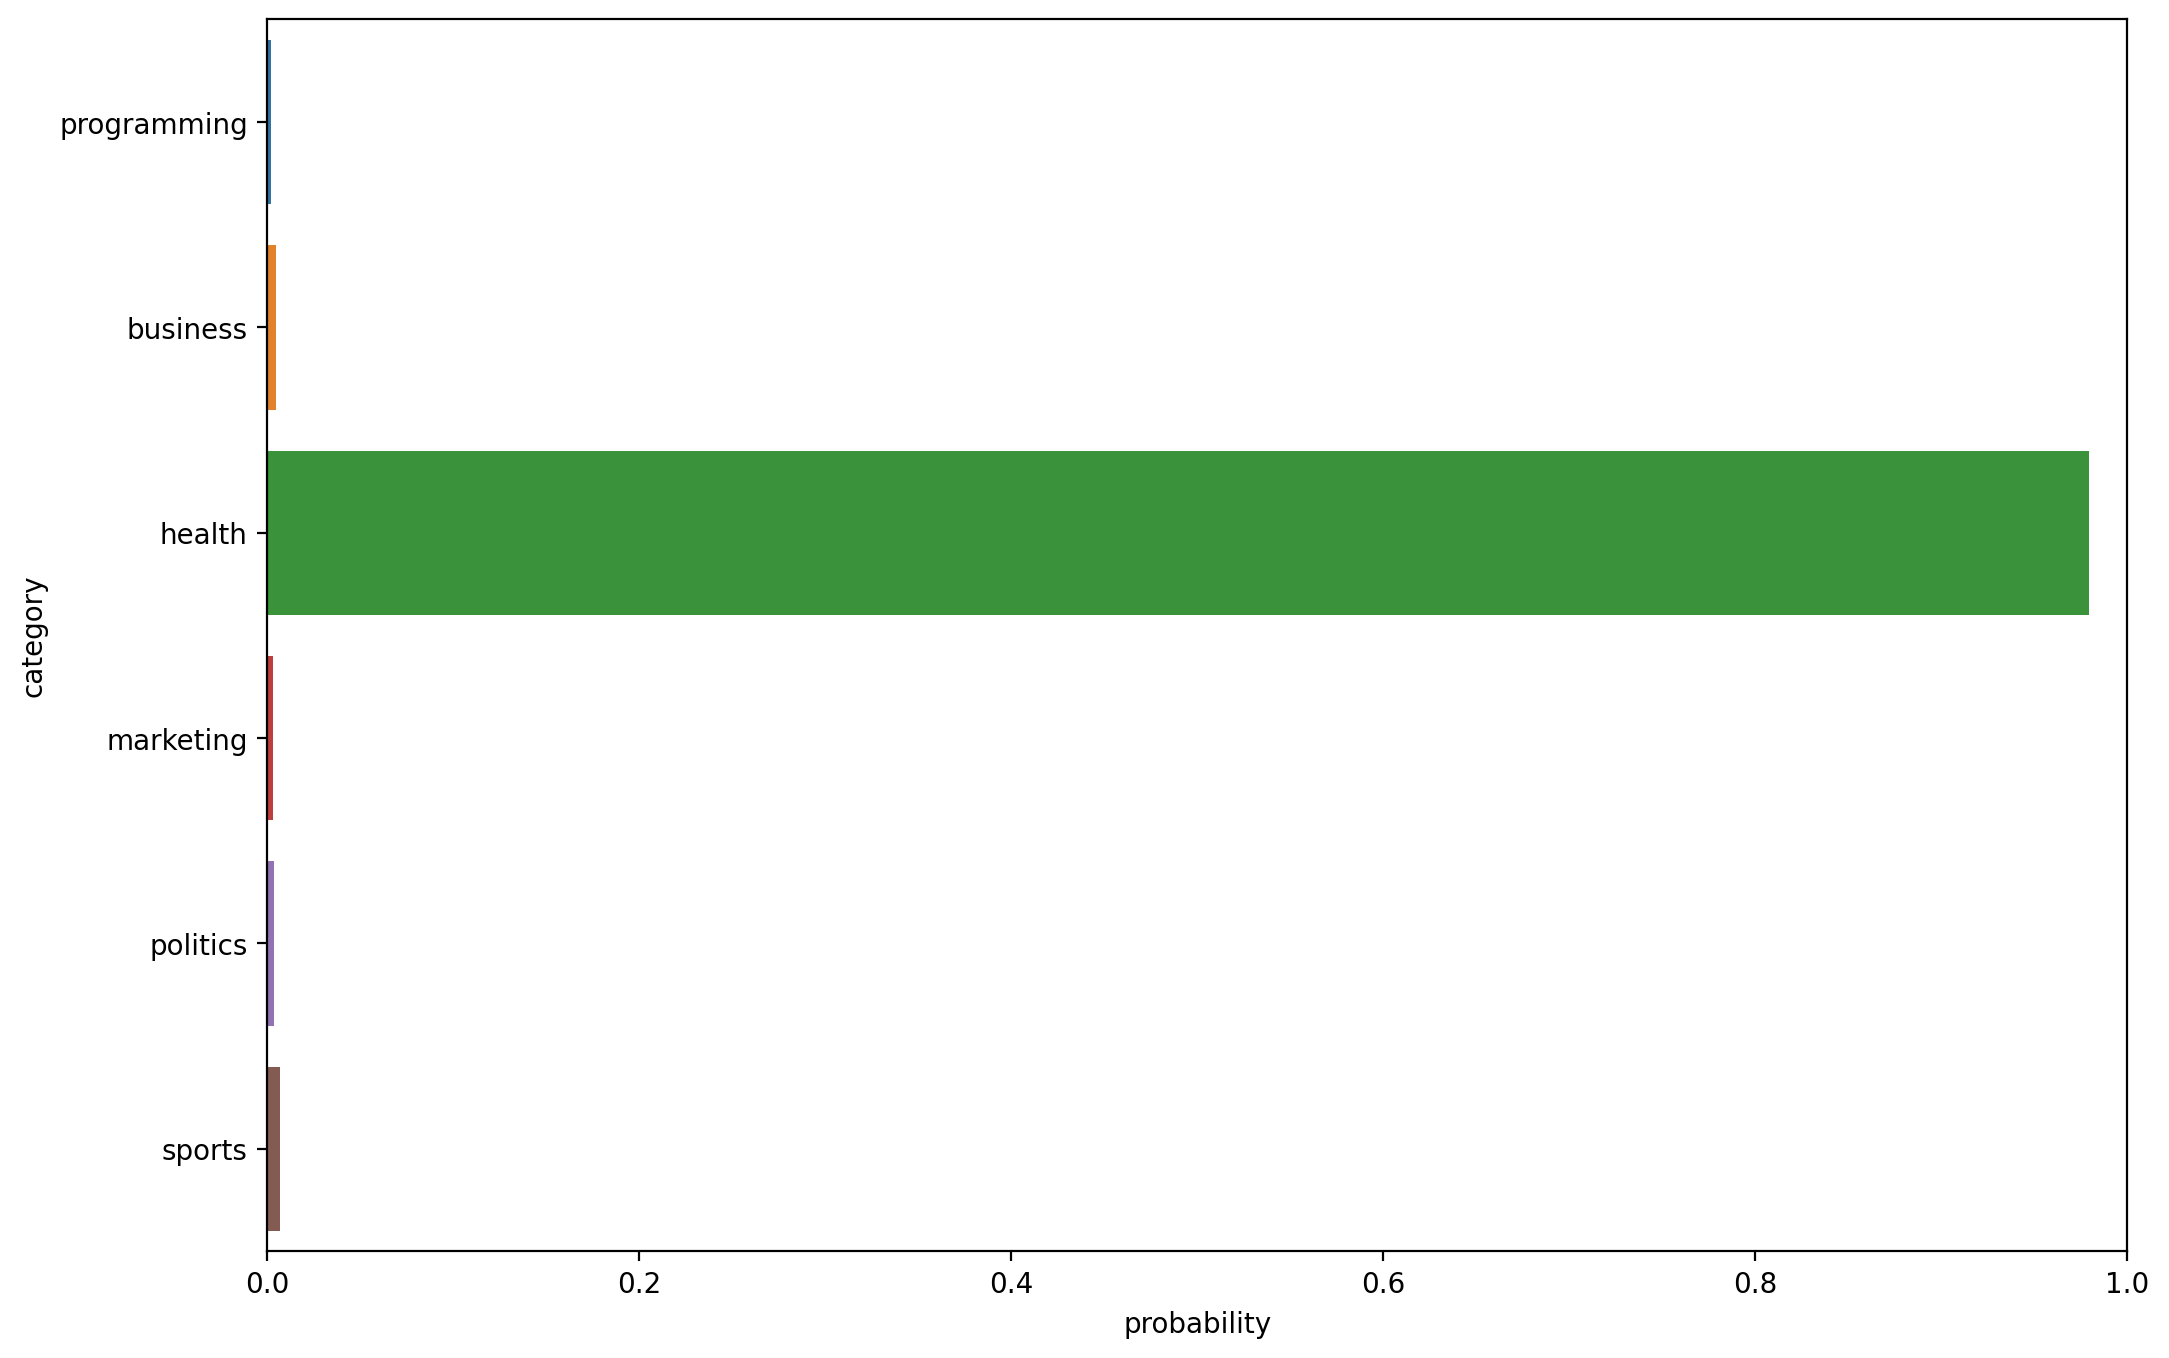

In [51]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('category')
plt.xlabel('probability')
plt.xlim([0, 1]);